# Imputación de Datos con KMeans

En este notebook se utiliza clustering KMeans para imputar valores faltantes. El número óptimo de clusters (K) se selecciona utilizando el coeficiente de silueta.

## Importar librerías necesarias

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

from ind import municipality_profile

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Lectura del dataset

In [21]:
df = pd.read_csv('../data/processed/dataset_municipal_v2.csv')
print(f"Shape del dataset: {df.shape}")
df.head()

Shape del dataset: (570, 134)


,cve_mun,municipio,pob_total,pob_indigena,pob_afrodescendiente,viv,viv_internet,viv_computadoras,viv_celular,ind_rez_social,...,licenciatura_percentage,especialidad_percentage,maestr_a_percentage,doctorado_percentage,indice_carencia_compuesto,pct_hacinamiento,pct_agua_entubada,pct_drenaje,pct_piso_tierra,pct_uso_lena
0,20001,Abejones,841,815,1,217,17,17,92,0.815821,...,12.646612,0.173986,0.79035,0.116028,19.447005,3.23,0.46,23.04,70.51,0.0
1,20002,Acatlán de Pérez Figueroa,45167,8548,316,12859,3700,1715,10141,0.066739,...,12.646612,0.173986,0.79035,0.116028,19.709153,8.72,5.52,5.44,78.87,0.0
2,20003,Asunción Cacalotepec,2547,2504,0,794,43,54,202,1.873466,...,12.646612,0.173986,0.79035,0.116028,31.435768,3.65,8.31,75.06,70.15,0.0
3,20004,Asunción Cuyotepeji,1107,3,15,342,60,47,118,-0.158009,...,12.646612,0.173986,0.79035,0.116028,19.532164,5.85,1.46,10.23,80.12,0.0
4,20005,Asunción Ixtaltepec,15261,10406,723,4828,1409,1013,3733,-0.494904,...,12.646612,0.173986,0.79035,0.116028,16.872411,6.30,1.82,2.55,73.70,0.0


## Identificar columnas con datos faltantes

In [22]:
to_keep = ["gini", "tasa_ingresos", "total_elementos_salud"]
all_cols_missing = []

# Mostrar conteo de valores faltantes por columna
print("Columnas con valores faltantes:")
print("=" * 50)
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df)) * 100
        print(f"{col}: {missing_count} ({missing_pct:.2f}%)")
        all_cols_missing.append(col)

# Eliminar columnas con valores faltantes excepto las que queremos conservar
to_remove = [col for col in all_cols_missing if col not in to_keep]
print(f"\nEliminando ({len(to_remove)}) columnas con valores faltantes")
df_cleaned = df.drop(columns=to_remove)
print(f"Nuevas dimensiones: {df_cleaned.shape}")

Columnas con valores faltantes:
gini: 4 (0.70%)
tasa_ingresos: 10 (1.75%)
cama_hospital: 534 (93.68%)
cama_fuera_hospital: 475 (83.33%)
cama_rec_nac: 537 (94.21%)
consultorios: 167 (29.30%)
equipamento: 510 (89.47%)
medicos_otros: 531 (93.16%)
medicos_gen_esp_odont: 199 (34.91%)
otro_pers: 455 (79.82%)
otro_pers_prof: 446 (78.25%)
enfermeria_contac_paciente: 180 (31.58%)
enfermeria_otras: 530 (92.98%)
medicos_adiest: 319 (55.96%)
per_tecnico: 421 (73.86%)
total_elementos_salud: 167 (29.30%)

Eliminando (13) columnas con valores faltantes
Nuevas dimensiones: (570, 121)


## Mostrar perfil antes de la imputación

In [23]:
muns = ["Matías Romero Avendaño", "Magdalena Mixtepec", "Asunción Cuyotepeji"]

In [24]:
for municipality_name in muns:
    print(f"\n\nPerfil del municipio antes de la imputación de datos:")
    _ = municipality_profile(df_cleaned, municipality_name)



Perfil del municipio antes de la imputación de datos:

================= PERFIL DEL MUNICIPIO: MATÍAS ROMERO AVENDAÑO =================

RESUMEN DEL PERFIL:
  • Marginación: Medio
  • Rezago social: Bajo
  • Conectividad: Conectividad media
  • Servicios básicos: Bajo acceso a servicios básicos
  • Salud: Acceso moderado a servicios de salud
  • Educación: Rezago educativo moderado
  • Desigualdad: Sin datos
  • Dependencia económica: Dependencia económica moderada


Perfil del municipio antes de la imputación de datos:

=================== PERFIL DEL MUNICIPIO: MAGDALENA MIXTEPEC ===================

RESUMEN DEL PERFIL:
  • Marginación: Alto
  • Rezago social: Muy alto
  • Conectividad: Baja conectividad
  • Servicios básicos: Muy bajo acceso a servicios básicos
  • Salud: Acceso moderado a servicios de salud
  • Educación: Rezago educativo moderado
  • Desigualdad: Desigualdad moderada
  • Dependencia económica: Sin datos


Perfil del municipio antes de la imputación de datos:

===

## Separar metadatos

In [25]:
metadata_cols = ["cve_mun", "municipio"]
metadata = df_cleaned[metadata_cols].copy()
df_features = df_cleaned.drop(columns=metadata_cols)

print(f"Columnas de características: {df_features.shape[1]}")
print(f"Columnas a imputar: {to_keep}")

Columnas de características: 119
Columnas a imputar: ['gini', 'tasa_ingresos', 'total_elementos_salud']


## Ejemplos de valores faltantes

In [26]:
# Para cada columna en to_keep, mostrar las primeras 3 filas con valores faltantes
to_show = []
for col in to_keep:
    missing_rows = df_features[df_features[col].isnull()].head(3)
    if not missing_rows.empty:
        print(f"\nPrimeras 3 instancias con valores vacíos en '{col}':")
        print("=" * 50)
        for index in missing_rows.index:
            municipio = metadata.loc[index, 'municipio']
            print(f"  Municipio: {municipio}")
        
        to_show.append({
            "column": col,
            "rows": missing_rows.index.tolist()
        })


Primeras 3 instancias con valores vacíos en 'gini':
  Municipio: Matías Romero Avendaño
  Municipio: San Francisco Chindúa
  Municipio: Santa María Chimalapa

Primeras 3 instancias con valores vacíos en 'tasa_ingresos':
  Municipio: Magdalena Mixtepec
  Municipio: San Andrés Tepetlapa
  Municipio: San Francisco Logueche

Primeras 3 instancias con valores vacíos en 'total_elementos_salud':
  Municipio: Asunción Cuyotepeji
  Municipio: Calihualá
  Municipio: Constancia del Rosario


## Preparación para clustering

Para poder aplicar KMeans, primero necesitamos:
1. Imputar temporalmente los valores faltantes con la media (para poder calcular clusters)
2. Estandarizar los datos
3. Encontrar el número óptimo de clusters usando el coeficiente de silueta

In [27]:
# Paso 1: Separar columnas numéricas y no numéricas
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df_features.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas no numéricas: {len(non_numeric_cols)}")
if non_numeric_cols:
    print(f"Columnas no numéricas encontradas: {non_numeric_cols[:5]}...")  # Mostrar solo las primeras 5

# Trabajar solo con columnas numéricas
df_numeric = df_features[numeric_cols].copy()

# Paso 2: Imputación temporal con la media para poder aplicar KMeans
temp_imputer = SimpleImputer(strategy='mean')
df_temp_imputed = pd.DataFrame(
    temp_imputer.fit_transform(df_numeric),
    columns=df_numeric.columns,
    index=df_numeric.index
)

# Paso 3: Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_temp_imputed)

print(f"\nDatos preparados para clustering: {df_scaled.shape}")


Columnas numéricas: 111
Columnas no numéricas: 8
Columnas no numéricas encontradas: ['grad_rez_social', 'grad_margi', 'clasificacion_escolaridad_prees', 'clasificacion_escolaridad_prim', 'clasificacion_escolaridad_sec']...

Datos preparados para clustering: (570, 111)


## Búsqueda del K óptimo usando Coeficiente de Silueta

El coeficiente de silueta mide qué tan similar es un objeto a su propio cluster comparado con otros clusters. El rango va de -1 a 1, donde:
- Valores cercanos a 1 indican que el objeto está bien agrupado
- Valores cercanos a 0 indican que el objeto está en el borde entre dos clusters
- Valores negativos indican que el objeto puede haber sido asignado al cluster incorrecto

In [28]:
# Probar diferentes valores de K
k_range = range(2, 11)  # Probar de 2 a 10 clusters
silhouette_scores = []
inertias = []

print("Calculando coeficientes de silueta...")
print("=" * 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    
    # Calcular coeficiente de silueta
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)
    
    print(f"K={k}: Coeficiente de silueta = {silhouette_avg:.4f}")

# Encontrar el K óptimo
optimal_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print("\n" + "=" * 50)
print(f"K óptimo: {optimal_k} (Coeficiente de silueta: {best_score:.4f})")
print("=" * 50)

Calculando coeficientes de silueta...
K=2: Coeficiente de silueta = 0.6505
K=3: Coeficiente de silueta = 0.5111
K=4: Coeficiente de silueta = 0.1300
K=5: Coeficiente de silueta = 0.1237
K=6: Coeficiente de silueta = 0.1335
K=7: Coeficiente de silueta = 0.1351
K=8: Coeficiente de silueta = 0.1365
K=9: Coeficiente de silueta = 0.1280
K=10: Coeficiente de silueta = 0.0877

K óptimo: 2 (Coeficiente de silueta: 0.6505)


## Visualización de resultados

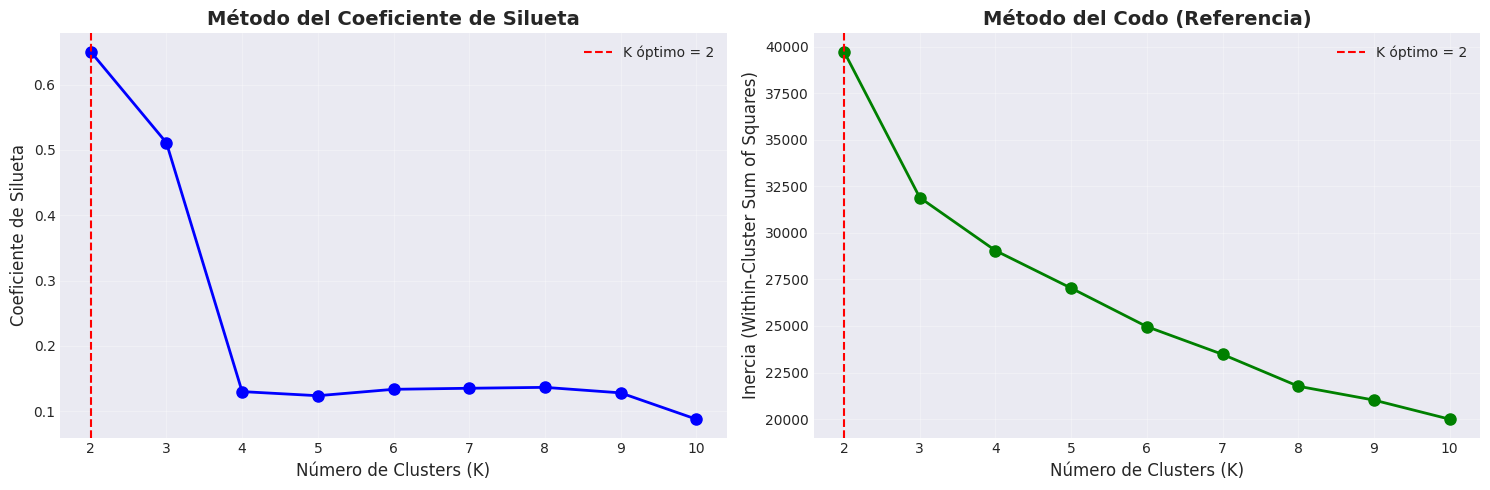


El K óptimo (2) maximiza el coeficiente de silueta.


In [29]:
# Crear gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Coeficiente de Silueta
ax1.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='r', linestyle='--', label=f'K óptimo = {optimal_k}')
ax1.set_xlabel('Número de Clusters (K)', fontsize=12)
ax1.set_ylabel('Coeficiente de Silueta', fontsize=12)
ax1.set_title('Método del Coeficiente de Silueta', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xticks(k_range)

# Gráfica 2: Método del Codo (Elbow Method) - como referencia
ax2.plot(k_range, inertias, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k, color='r', linestyle='--', label=f'K óptimo = {optimal_k}')
ax2.set_xlabel('Número de Clusters (K)', fontsize=12)
ax2.set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12)
ax2.set_title('Método del Codo (Referencia)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(k_range)

plt.tight_layout()
plt.show()

print(f"\nEl K óptimo ({optimal_k}) maximiza el coeficiente de silueta.")

## Aplicar KMeans con K óptimo

In [30]:
# Entrenar KMeans con el K óptimo
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Agregar las etiquetas de cluster al dataframe
df_features['cluster'] = cluster_labels

print(f"Clustering completado con K={optimal_k}")
print("\nDistribución de clusters:")
print(df_features['cluster'].value_counts().sort_index())

Clustering completado con K=2

Distribución de clusters:
cluster
0    543
1     27
Name: count, dtype: int64


## Imputación usando la media del cluster

Para cada valor faltante, lo imputamos con la media de su cluster correspondiente.

In [31]:
# Crear una copia del dataframe numérico original para imputación
df_imputed = df_numeric.copy()
df_imputed['cluster'] = cluster_labels

# Para cada columna con valores faltantes
for col in to_keep:
    missing_mask = df_imputed[col].isnull()
    
    if missing_mask.any():
        print(f"\nImputando '{col}'...")
        
        # Para cada cluster
        for cluster_id in range(optimal_k):
            # Obtener la máscara de este cluster
            cluster_mask = df_imputed['cluster'] == cluster_id
            
            # Combinar: valores faltantes Y en este cluster
            impute_mask = missing_mask & cluster_mask
            
            if impute_mask.any():
                # Calcular la media del cluster (sin incluir NaN)
                cluster_mean = df_imputed.loc[cluster_mask, col].mean()
                
                # Si todos los valores del cluster son NaN, usar la media global
                if pd.isna(cluster_mean):
                    cluster_mean = df_imputed[col].mean()
                
                # Imputar
                df_imputed.loc[impute_mask, col] = cluster_mean
                
                n_imputed = impute_mask.sum()
                print(f"  Cluster {cluster_id}: {n_imputed} valores imputados con media = {cluster_mean:.4f}")

# Redondear 'total_elementos_salud' a entero
df_imputed['total_elementos_salud'] = df_imputed['total_elementos_salud'].round().astype(int)

print("\n" + "=" * 50)
print("Imputación completada exitosamente")
print("=" * 50)



Imputando 'gini'...
  Cluster 0: 3 valores imputados con media = 0.3761
  Cluster 1: 1 valores imputados con media = 0.3919

Imputando 'tasa_ingresos'...
  Cluster 0: 10 valores imputados con media = 0.1637

Imputando 'total_elementos_salud'...
  Cluster 0: 167 valores imputados con media = 28.7340

Imputación completada exitosamente


## Verificar que no quedan valores faltantes

In [32]:
print("Valores faltantes después de la imputación:")
print("=" * 50)
for col in to_keep:
    missing_count = df_imputed[col].isnull().sum()
    print(f"{col}: {missing_count} valores faltantes")

if df_imputed[to_keep].isnull().sum().sum() == 0:
    print("\n✓ Todos los valores han sido imputados correctamente")
else:
    print("\n✗ Aún quedan valores faltantes")

Valores faltantes después de la imputación:
gini: 0 valores faltantes
tasa_ingresos: 0 valores faltantes
total_elementos_salud: 0 valores faltantes

✓ Todos los valores han sido imputados correctamente


Agregar columnas de metadatos nuevamente

In [33]:
# contatenar metadata y df_imputed (agregar columnas no numéricas en non_numeric_cols)
df_final = pd.concat([metadata, df_imputed, df_features[non_numeric_cols]], axis=1)
print(f"\nDimensiones del dataset final: {df_final.shape}")
df_final.head()


Dimensiones del dataset final: (570, 122)


,cve_mun,municipio,pob_total,pob_indigena,pob_afrodescendiente,viv,viv_internet,viv_computadoras,viv_celular,ind_rez_social,...,pct_uso_lena,cluster,grad_rez_social,grad_margi,clasificacion_escolaridad_prees,clasificacion_escolaridad_prim,clasificacion_escolaridad_sec,clasificacion_dispersion_educativa_prees,clasificacion_dispersion_educativa_prim,clasificacion_dispersion_educativa_sec
0,20001,Abejones,841,815,1,217,17,17,92,0.815821,...,0.0,0,Medio,Alto,Alto,Alto,Bajo,Bajo,Bajo,Bajo
1,20002,Acatlán de Pérez Figueroa,45167,8548,316,12859,3700,1715,10141,0.066739,...,0.0,1,Bajo,Medio,Medio,Alto,Bajo,Bajo,Bajo,Medio
2,20003,Asunción Cacalotepec,2547,2504,0,794,43,54,202,1.873466,...,0.0,0,Muy alto,Alto,Alto,Alto,Bajo,Bajo,Bajo,Medio
3,20004,Asunción Cuyotepeji,1107,3,15,342,60,47,118,-0.158009,...,0.0,0,Bajo,Medio,Medio,Alto,Bajo,Medio,Medio,Medio
4,20005,Asunción Ixtaltepec,15261,10406,723,4828,1409,1013,3733,-0.494904,...,0.0,0,Bajo,Bajo,Alto,Alto,Bajo,Medio,Medio,Alto


## Mostrar los valores imputados

In [34]:
print("Valores imputados para las instancias previamente identificadas:")
print("=" * 70)

for item in to_show:
    col = item["column"]
    rows = item["rows"]
    print(f"\nValores imputados para '{col}':")
    print(df_final.loc[rows, ["municipio", col]])

Valores imputados para las instancias previamente identificadas:

Valores imputados para 'gini':
                  municipio      gini
56   Matías Romero Avendaño  0.391887
139   San Francisco Chindúa  0.376094
406   Santa María Chimalapa  0.376094

Valores imputados para 'tasa_ingresos':
                  municipio  tasa_ingresos
47       Magdalena Mixtepec       0.163688
98     San Andrés Tepetlapa       0.163688
145  San Francisco Logueche       0.163688

Valores imputados para 'total_elementos_salud':
                 municipio  total_elementos_salud
3      Asunción Cuyotepeji                     29
10               Calihualá                     29
19  Constancia del Rosario                     29


## Análisis de resultados por cluster

In [35]:
# Estadísticas descriptivas por cluster para las columnas imputadas
print("Estadísticas por cluster para las columnas imputadas:")
print("=" * 70)

for col in to_keep:
    print(f"\n{col.upper()}:")
    print("-" * 70)
    cluster_stats = df_imputed.groupby('cluster')[col].agg(['count', 'mean', 'std', 'min', 'max'])
    print(cluster_stats)

Estadísticas por cluster para las columnas imputadas:

GINI:
----------------------------------------------------------------------
         count      mean       std       min       max
cluster                                               
0          543  0.376094  0.026873  0.309752  0.496749
1           27  0.391887  0.032477  0.342847  0.477115

TASA_INGRESOS:
----------------------------------------------------------------------
         count      mean       std       min       max
cluster                                               
0          543  0.163688  0.032404  0.079902  0.293365
1           27  0.131234  0.015189  0.098022  0.159137

TOTAL_ELEMENTOS_SALUD:
----------------------------------------------------------------------
         count        mean         std  min   max
cluster                                          
0          543   28.815838  105.407079    1  2297
1           27  336.592593  542.988260    3  2726


## Visualización de clusters (PCA para 2D)

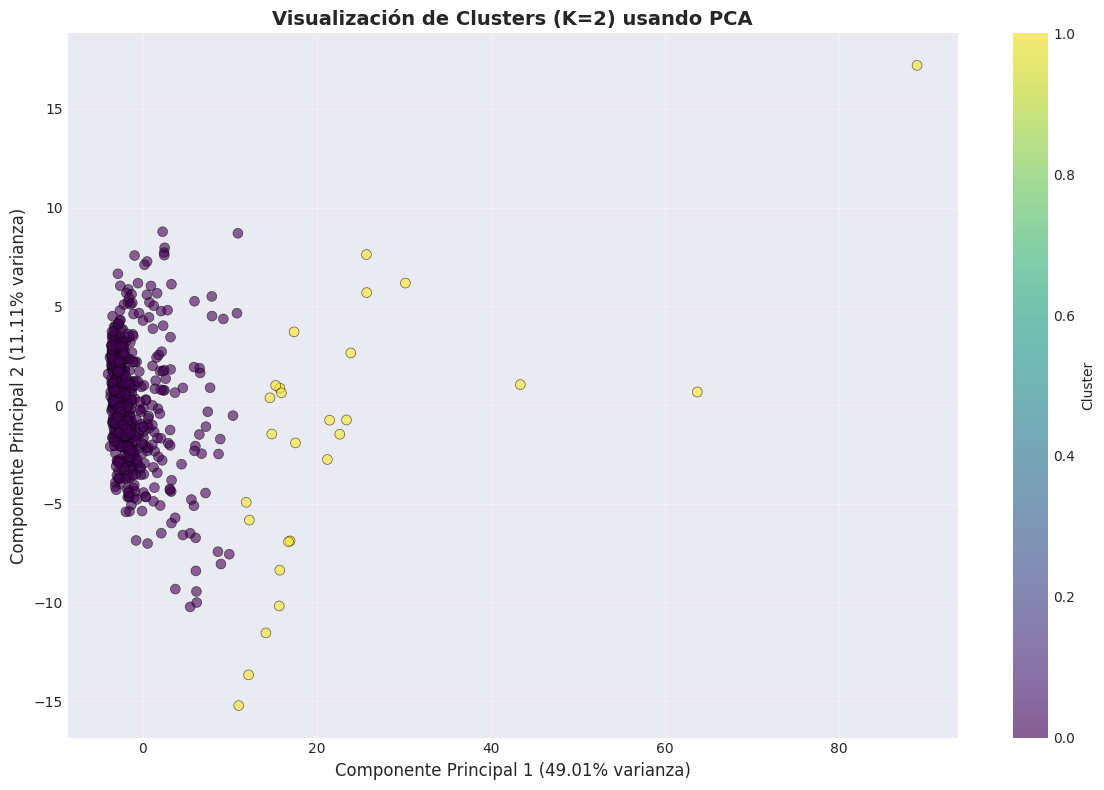


Varianza explicada total: 60.12%


In [36]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones para visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Crear visualización
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     alpha=0.6, 
                     edgecolors='black',
                     linewidth=0.5,
                     s=50)

plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} varianza)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} varianza)', fontsize=12)
plt.title(f'Visualización de Clusters (K={optimal_k}) usando PCA', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nVarianza explicada total: {sum(pca.explained_variance_ratio_):.2%}")

## Mostrar perfil después de la imputación

In [37]:
# show profile after imputation
for municipality_name in muns:
    print(f"\n\nPerfil del municipio después de la imputación de datos:")
    _ = municipality_profile(df_final, municipality_name)



Perfil del municipio después de la imputación de datos:

================= PERFIL DEL MUNICIPIO: MATÍAS ROMERO AVENDAÑO =================

RESUMEN DEL PERFIL:
  • Marginación: Medio
  • Rezago social: Bajo
  • Conectividad: Conectividad media
  • Servicios básicos: Bajo acceso a servicios básicos
  • Salud: Acceso moderado a servicios de salud
  • Educación: Rezago educativo moderado
  • Desigualdad: Desigualdad moderada
  • Dependencia económica: Dependencia económica moderada


Perfil del municipio después de la imputación de datos:

=================== PERFIL DEL MUNICIPIO: MAGDALENA MIXTEPEC ===================

RESUMEN DEL PERFIL:
  • Marginación: Alto
  • Rezago social: Muy alto
  • Conectividad: Baja conectividad
  • Servicios básicos: Muy bajo acceso a servicios básicos
  • Salud: Acceso moderado a servicios de salud
  • Educación: Rezago educativo moderado
  • Desigualdad: Desigualdad moderada
  • Dependencia económica: Alta dependencia económica


Perfil del municipio despu